# Introduction

In this project, we evaluate the performances of two models: Pegasus and GPT-3 on text summarization. 

First, we generate summaries using baseline methods, pegasus, and GPT-3 before and after fine-tuning . Then we evaluate the quality of these generations using the ROUGE metric. Since the evaluation metric is still a field of active research, to compensate for the weakness of ROUGE, we manually evaluate the quality of a sampled summary.

# Preparing Environment

We first need to install several packages. Note that the sentencepiece should be installed along with transformers. According to its [GitHub repository](https://github.com/google/sentencepiece) [1]:

> SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) and unigram language model) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.




In [ ]:
!pip -q install transformers[sentencepiece] datasets
!pip install -q py7zr

     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 451 kB 83.9 MB/s 
     |████████████████████████████████| 212 kB 86.2 MB/s 
     |████████████████████████████████| 115 kB 84.3 MB/s 
     |████████████████████████████████| 182 kB 88.1 MB/s 
     |████████████████████████████████| 127 kB 88.9 MB/s 
     |████████████████████████████████| 7.6 MB 84.2 MB/s 
     |████████████████████████████████| 1.3 MB 75.3 MB/s 
     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 2.3 MB 10.1 MB/s 
     |████████████████████████████████| 138 kB 86.6 MB/s 
     |████████████████████████████████| 379 kB 87.6 MB/s 
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 357 kB 84.1 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 


# Load Datasets

In [ ]:
from transformers import pipeline, set_seed
from datasets import DatasetDict, load_dataset
# use pickle to save files
import pickle 

According to the [🤗 website](https://huggingface.co/datasets/samsum) [2]:
> The SAMSum dataset contains about 16k messenger-like conversations with summaries. Conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger conversations. The style and register are diversified - conversations could be informal, semi-formal or formal, they may contain slang words, emoticons and typos. Then, the conversations were annotated with summaries. It was assumed that summaries should be a concise brief of what people talked about in the conversation in third person.

In [ ]:
dataset = load_dataset('samsum')

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Since generating texts and fine-tuning on datasets take much computing resources and the GPT-3 models also charge a lot based on the number of tokens used. As of the time of writing, the author of this project does not have adequate computing-resources to do both tasks on the full dataset. Instead, we generate a small size dataset for test run and test fine-tuning (1/100 of the original size). Hope this will also provide insights on how well the models work on summarization task.

In [ ]:
train_sampled = dataset['test'].shuffle(seed=42).select(range(100))
validation_sampled = dataset['test'].shuffle(seed=42).select(range(100,200))
test_sampled = dataset['test'].shuffle(seed=42).select(range(200, 300))

# EDA

Let's see what it looks like for a dialogue and a summary. It seems that the summary of really of high quality which is consistent with the statement by Samsung that they were generated by language experts. 

In [ ]:
sample = dataset['train'][2]
print('DIALOGUE:', 
      '\n', 
      sample['dialogue'], 
      '\n\n', 
      'SUMMARY:', 
      '\n', 
      sample['summary'])

DIALOGUE: 
 Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style 

 SUMMARY: 
 Kim may try the pomodoro technique recommended by Tim to get more stuff done.


To guide us selecting text-generation parameters, we need to look at the lengths of dialogue and reference summaries. We first extract the lengths and plot then as histograms. It appears that most of the dialogues and references are less than 1000 words and 150 words respectively. Later we will set the maximum input and output text according to these numbers.

In [ ]:
len_dialogue = [len(a) for a in dataset['train']['dialogue']]
len_summary = [len(h) for h in dataset['train']['summary']]

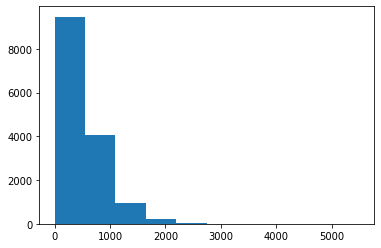

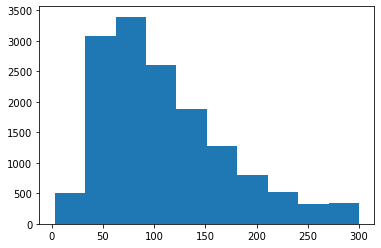

In [ ]:
from matplotlib import pyplot as plt

plt.hist(len_dialogue, 10)
plt.show()

plt.hist(len_summary, 10)
plt.show()

# Summarizations

## Baseline

We first use NLTK to create a leading-three-sentences summaries for our dialogues. This will work as our baseline for model comparisons. To do this we need to use NLTK's `sent_tokenize` method as it can help us split a paragraph into sentences. We cannot simply split paragraphs by '.', since This will incorrectly split a sentence like "The U.N. is an organization." into 3 separate pieces.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

The `three_sentence_summary` function takes in a paragraph and outputs its first three sentences joined with '\n'.

In [ ]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

The `get_baseline_sum` takes in a dataset and the column name and outputs a list of three-sentence-summaries for the selected column in the dataset.

In [ ]:
def get_baseline_sum(dataset, column_text):
  summaries_baseline = [three_sentence_summary(text) for text in dataset[column_text]]
  return summaries_baseline

summaries_baseline = get_baseline_sum(test_sampled, 'dialogue')
summaries_baseline[:3]

['Salma: <file_video>\r\nSalma: the latest cat meme\r\nHugh: oh sweet, I can never get enough of those lol\r\nHugh: <file_photo>\r\nSalma: hahaha same',
 "Debbie: Help, I don't know which dress to buy!\n<file_photo> or <file_photo>?\nKelly: The red one!",
 "Derek McCarthy: Filip - are you around?\nWould you have an Android cable I could borrow for an hour?\nI'm almost out of charge and I have a power pack  but forgot my cable😭\r\nTommy: I am in Poland but can ring my wife and she will give you one\r\nTommy: Do you want me to?"]

Since text generation is a time-consuming process, when we get the summaries, we should save them in Google Drive automatically for future evaluations.

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Datasets

/content/drive/MyDrive/Colab Notebooks/Datasets


In [ ]:
with open("summaries_baseline", "wb") as file:   # pickling
  pickle.dump(summaries_baseline, file)

## PEGASUS

The Pegasus model was proposed in PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization by Jingqing Zhang, Yao Zhao, Mohammad Saleh and Peter J. Liu on Dec 18, 2019.

According to the paper's abstract:

- Pegasus’ pretraining task is intentionally similar to summarization: important sentences are removed/masked from an input document and are generated together as one output sequence from the remaining sentences, similar to an extractive summary.
- Pegasus achieves SOTA summarization performance on all 12 downstream tasks, as measured by ROUGE and human evaluation.

#### PEGASUS without fine-tuning

The PEGASUS model is trained with sampled gap sentence ratios on both C4 and HugeNews, and stochastically sample important sentences. In this project, we use the version that has been fine-tuned on CNN / DailyMail Dataset which is an English-language dataset containing more than 300k unique news articles published by CNN and the Daily Mail.

Since every generated token requires a forward pass through the model, generating just 100 tokens for each sample will require 1 million forward passes. If we consider beam-searching, this number also needs to multiply the number of beams used. Therefore, text generation is a very slow process. To know where we are in the process, we define a chunks generator and tqdm to produce the progress bars. 

In [ ]:
from transformers import pipeline, set_seed
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

Here we define a function to automate the summaries generation process. Since most of our dialogues have less than 1000 words and max input sentence length for `pegasus-cnn_dailymail` is 1024, we truncate the input text to 1024 if applicable and set the maximum output's length to 150 words. Using these limits, we assume the majority of information contained in the sentence would be preserved. Then we save the processed outputs into a list.


In [ ]:
def evaluate_summaries_pegasus(dataset, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="dialogue", 
                               column_summary="summary"):
    dialogue_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    summaries_peg = []

    for dialogue_batch, target_batch in tqdm(
        zip(dialogue_batches, target_batches), total=len(dialogue_batches)):
        
        inputs = tokenizer(dialogue_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, # penalize the generation of long seq
                         num_beams=8, 
                         max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace(".<n>", '.\n').replace('\xa0', ' ') for d in decoded_summaries]
        summaries_peg.extend(decoded_summaries)
    
    return summaries_peg

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

summaries_peg = evaluate_summaries_pegasus(test_sampled, 
                                   model, tokenizer, batch_size=8)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]


100%|██████████| 13/13 [02:15<00:00, 10.40s/it]


In [ ]:
summaries_peg[0]

'Hugh: oh sweet, I can never get enough of those.\nSalma: hahaha same.\nHugh: oh sweet, I can never get enough of those.'

In [ ]:
with open("summaries_peg", "wb") as file:   # pickling
  pickle.dump(summaries_peg, file) # save to Google Drive

#### PEGASUS with fine-tuning 

We create a `convert_examples_to_features` function to convert a batch of examples into the input format for the model.

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_pt = dataset.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The default data collator simply stacks all the tensors from the batch. But for summarization tasks we also need to prepare the targets for the decoder. PEGASUS has a classic seq2seq architecture. We would apply "teacher forcing" in the decoder, with which the decoder receives the encoder output and input tokens that consists of the labels shifted by one. In this way, the decoder gets the ground truth shifted by one as an input while predicting the next token. The `DataCollatorForSeq2Seq` will also set the padding tokens to -100 so that they would be ignore by the loss function.

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Due to the huge size of the text-generation model, when defining the `training_args`, we set the batch size to 1 and use `gradient_accumulation_steps` to sum up all the gradients for parameters' update use.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

We also need to save the trained model on 🤗 Hub for the future use. Then we can put all the arguments into the trainer and start the training process. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_pt["train"], 
                  eval_dataset=dataset_pt["validation"])

Cloning https://huggingface.co/lddczcn/pegasus-samsum into local empty directory.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

Step,Training Loss,Validation Loss
500,1.701600,1.481896


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=920, training_loss=1.8295823231987332, metrics={'train_runtime': 1882.8802, 'train_samples_per_second': 7.824, 'train_steps_per_second': 0.489, 'total_flos': 5526961323663360.0, 'train_loss': 1.8295823231987332, 'epoch': 1.0})

In [ ]:
# save the model to 🤗 hub
trainer.push_to_hub("training complete @ 11.16--9PM")

🤗 Transformers has a centralized logging system and the default verbosity of the library is WARNING which will pit off more information than we need. We can use the direct setter to change the verbosity to the ERROR level.

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

Finally, we can load our trained model and use it to generate summaries.

In [ ]:
model_ckpt = "lddczcn/pegasus-samsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
summaries_peg_ft = evaluate_summaries_pegasus(test_sampled, 
                                   model, tokenizer, batch_size=8)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


In [ ]:
summaries_peg_ft[0]

"Salma and Hugh are watching the latest cat meme. Hugh can't get enough of them, so they send him a picture of the cat and Salma a video."

In [ ]:
with open("summaries_peg_ft", "wb") as file:   #pickling
  pickle.dump(summaries_peg_ft, file) # save it to Google Drive

## GPT-3

Generative Pre-trained Transformer (GPT-3) is one of the most popular cutting-edge language models. It is an autoregressive language model that uses deep learning to produce human-like text. GPT-3 is trained on over 175 billion parameters on 45 TB of text sourced from all over the internet. Among many cool features that OpenAI API provides, we will test its power on text summarizations in this project.

We first install OpenAI packages, and to perform fine-tuning on it, we need to upgrade to use its command-line interface (CLI).

In [ ]:
!pip install -q openai
!pip install -q --upgrade openai

import openai
openai.api_key = "hide-key"

     |████████████████████████████████| 44 kB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 9.4 MB/s 


### GPT-3 Curie without fine-tuning

---



The GPT-3 model has 4 versions available in OpenAI's API: Davinci, Curie, Babbage and ADA and the first two of which are good at text summarizations. According to OpenAI's website, the Davinci model is superior to the Curie model in the following aspects:
> The Davinci model provides a decent summary which is very short and almost the same even after multiple attempts. The Curie model provides a good summary by covering the key elements– author’s introduction, research conducted by the author, the kind of dilemmas that organizations go through while posting on social media, and the description of the framework. From the examples above, it is fair to say that summaries provided by the Curie model cover all the key points, not only offering a better summary of the passage but also a good variation in the three summaries.

> While Curie was not able to detect spelling errors, Davinci corrected them.

> Although Curie is good at extractive summary, it is not as good as Davinci at solving logical problems. 

In this project, we only go with the Curie model since the cost of Davinci model is 10 times that of the Curie model. 

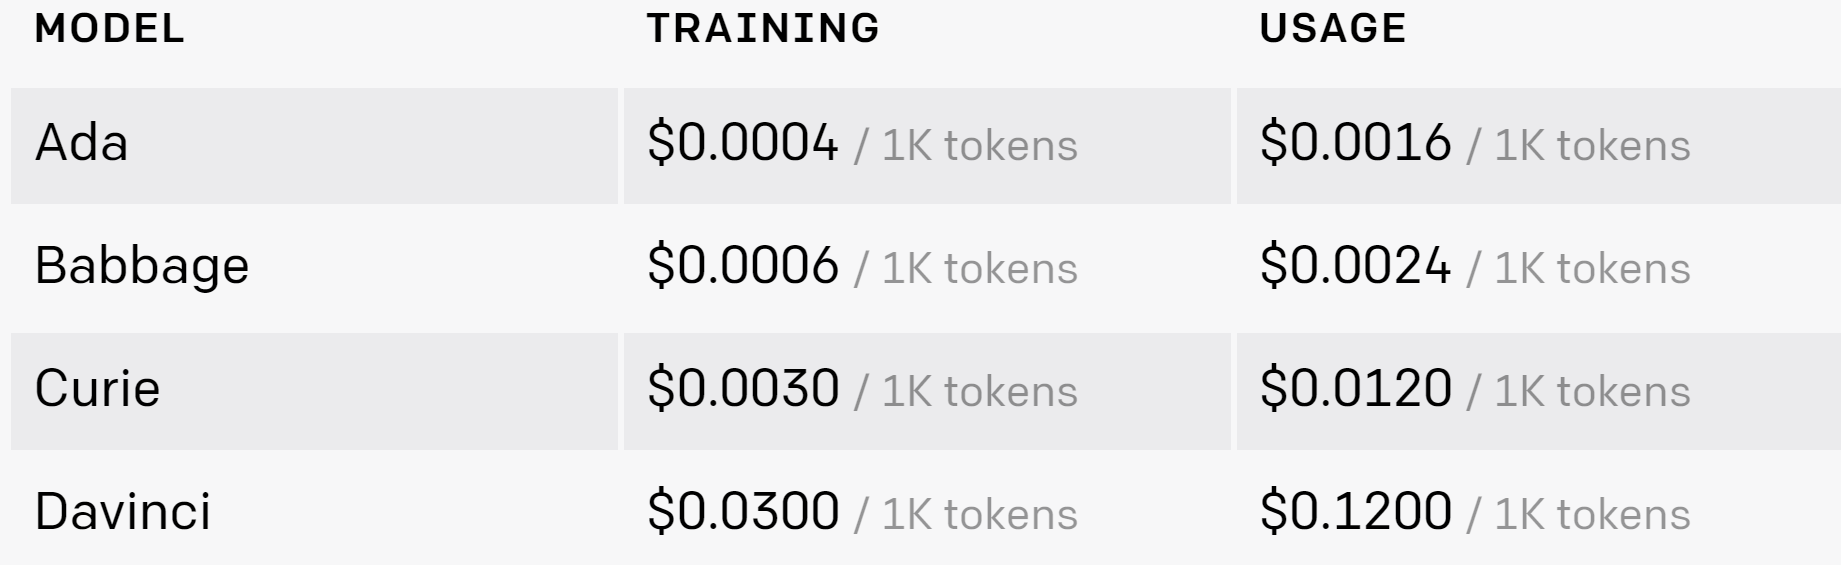


We also need to truncate dialogue since according the OpenAI API doc, the max request limit is 2048 tokens, and each token is approximately 4 letters. Recall: request = input + output. For safety, we only use the first 7500 letters (approximately 1875 tokens) of the dialogue as input. Since most of the reference summaries are shorter than 150 words, it is also reasonable to the outputs' length limit to 180 tokens.

In [ ]:
def get_gpt3_sum(dataset):
    summaries_gpt3 = []
    tldr_tag = "\n tl;dr:"
   
    for dialogue in dataset['dialogue']:    
        text = dialogue[:7500] + tldr_tag
        response = openai.Completion.create(engine="curie",
                                            prompt=text,
                                            temperature=0.4,
                                            max_tokens=180,
                                            top_p=1,
                                            frequency_penalty=0,
                                            presence_penalty=0,
                                            stop=["\n"]
        )
        summaries_gpt3.append(response["choices"][0]["text"])
    
    return summaries_gpt3

In [ ]:
summaries_gpt3 = get_gpt3_sum(test_sampled)

In [ ]:
with open("summaries_gpt3", "wb") as file:   #pickling
  pickle.dump(summaries_gpt3, file) 

### GPT-3 Curie with fine-tuning

OpenAI also released a fine-tuning API for GPT-3, allowing better performance than few-shots prompting, especially when having datasets larger than few hundred samples.

#### Prepare and upload files

Our data must be a JSONL document, where each line is a prompt-completion pair corresponding to a training example. We can use OpenAI's CLI data preparation tool to easily convert data into this file format. After conversion, we need to save them in designated files and mark them with the purpose of "fine-tune".

In [ ]:
train_sampled_csv = train_sampled.rename_columns({'dialogue': 'prompt', 'summary': 'completion'}).to_csv('/content/sample_data/train.csv')
validation_sampled_csv = validation_sampled.rename_columns({'dialogue': 'prompt', 'summary': 'completion'}).to_csv('/content/sample_data/valid.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
cd sample_data

In [ ]:
ls

In [ ]:
!openai tools fine_tunes.prepare_data -f train.csv

Analyzing...

- Based on your file extension, your file is formatted as a CSV file
- Your file contains 100 prompt-completion pairs
- The input file should contain exactly two columns/keys per row. Additional columns/keys present are: ['Unnamed: 0', 'id']
- There are 1 examples that are very long. These are rows: [54]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- Your data does not contain a common ending at the end of your completions. Having a common ending string appended to the end of the completion makes it clearer to the fine-tune

In [ ]:
openai.File.create(
  file=open("train_prepared.jsonl", "rb"),
  purpose='fine-tune'
)


<File file id=file-Nx8pi7LnhJ0ZhuSzN4jxvEhW at 0x7f6142cd41d0> JSON: {
  "bytes": 383056,
  "created_at": 1668539126,
  "filename": "file",
  "id": "file-Nx8pi7LnhJ0ZhuSzN4jxvEhW",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}

In [ ]:
!openai tools fine_tunes.prepare_data -f valid.csv

In [ ]:
openai.File.create(
  file=open("valid_prepared.jsonl", "rb"),
  purpose='fine-tune'
)


<File file id=file-JiOU7MULmlwttVffvXTqnt7r at 0x7f6142cd4590> JSON: {
  "bytes": 446272,
  "created_at": 1668539288,
  "filename": "file",
  "id": "file-JiOU7MULmlwttVffvXTqnt7r",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}

#### Fine-tune GPT-3 curie

Once the files are prepared, we simply call OpenAI's API to fine-tune the curie model.

In [ ]:
openai.FineTune.create(training_file="file-Nx8pi7LnhJ0ZhuSzN4jxvEhW",
                       validation_file="file-JiOU7MULmlwttVffvXTqnt7r",
                        model="curie")

<FineTune fine-tune id=ft-ksFv7QIG6BSahelwkwq35iw9 at 0x7f613bca92f0> JSON: {
  "created_at": 1668540423,
  "events": [
    {
      "created_at": 1668540423,
      "level": "info",
      "message": "Created fine-tune: ft-ksFv7QIG6BSahelwkwq35iw9",
      "object": "fine-tune-event"
    }
  ],
  "fine_tuned_model": null,
  "hyperparams": {
    "batch_size": null,
    "learning_rate_multiplier": null,
    "n_epochs": 4,
    "prompt_loss_weight": 0.01
  },
  "id": "ft-ksFv7QIG6BSahelwkwq35iw9",
  "model": "curie",
  "object": "fine-tune",
  "organization_id": "org-CIh648l1Y4PmmVd3UT7ouRp3",
  "result_files": [],
  "status": "pending",
  "training_files": [
    {
      "bytes": 383056,
      "created_at": 1668539126,
      "filename": "file",
      "id": "file-Nx8pi7LnhJ0ZhuSzN4jxvEhW",
      "object": "file",
      "purpose": "fine-tune",
      "status": "processed",
      "status_details": null
    }
  ],
  "updated_at": 1668540423,
  "validation_files": [
    {
      "bytes": 446272,
   

We can also list the current status of the fine-tuning tasks.

In [ ]:
openai.FineTune.list()

<OpenAIObject list at 0x7f613bc91710> JSON: {
  "data": [
    {
      "created_at": 1668540423,
      "fine_tuned_model": "curie:ft-personal-2022-11-15-19-31-28",
      "hyperparams": {
        "batch_size": 1,
        "learning_rate_multiplier": 0.1,
        "n_epochs": 4,
        "prompt_loss_weight": 0.01
      },
      "id": "ft-ksFv7QIG6BSahelwkwq35iw9",
      "model": "curie",
      "object": "fine-tune",
      "organization_id": "org-CIh648l1Y4PmmVd3UT7ouRp3",
      "result_files": [
        {
          "bytes": 25113,
          "created_at": 1668540689,
          "filename": "compiled_results.csv",
          "id": "file-czkPU2EKmjdRsJtJ7XwWswBL",
          "object": "file",
          "purpose": "fine-tune-results",
          "status": "processed",
          "status_details": null
        }
      ],
      "status": "succeeded",
      "training_files": [
        {
          "bytes": 383056,
          "created_at": 1668539126,
          "filename": "file",
          "id": "file-Nx

Then we can check fine-tuning results by using its ID. In the output of the following code, we can see the fine-tuning task is processed and we can proceed to use fine-tuned model.

In [ ]:
openai.FineTune.retrieve(id="ft-ksFv7QIG6BSahelwkwq35iw9")

<FineTune fine-tune id=ft-ksFv7QIG6BSahelwkwq35iw9 at 0x7fba909f6050> JSON: {
  "created_at": 1668540423,
  "events": [
    {
      "created_at": 1668540423,
      "level": "info",
      "message": "Created fine-tune: ft-ksFv7QIG6BSahelwkwq35iw9",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1668540439,
      "level": "info",
      "message": "Fine-tune costs $0.99",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1668540439,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 0",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1668540445,
      "level": "info",
      "message": "Fine-tune started",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1668540538,
      "level": "info",
      "message": "Completed epoch 1/4",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1668540582,
      "level": "info",
      "message": "Completed epoch 2/4",
      "object": "fine-tune

#### Generate summaries

In [ ]:
def get_gpt3_ft_sum(dataset):
    summaries_gpt3_ft = []
    tldr_tag = "\n tl;dr:"
   
    for dialogue in dataset['dialogue']:    
        text = dialogue[:7500] + tldr_tag
        response = openai.Completion.create(model="curie:ft-personal-2022-11-15-19-31-28",
                                            prompt=text,
                                            temperature=0.4,
                                            max_tokens=180,
                                            top_p=1,
                                            frequency_penalty=0,
                                            presence_penalty=0,
                                            stop=["\n"]
        )
        summaries_gpt3_ft.append(response["choices"][0]["text"])
    
    return summaries_gpt3_ft

In [ ]:
summaries_gpt3_ft = get_gpt3_ft_sum(test_sampled)

In [ ]:
summaries_gpt3_ft[1]

" Kelly doesn't know which dress to buy, so Debbie sends her the link to a dress she thinks Kelly will like."

GPT-3 is very expensive, so are the summaries generated by GPT-3. After we generate the summarizations, we'd better save it to a list for future use.

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Datasets

/content/drive/MyDrive/Colab Notebooks/Datasets


In [ ]:
with open("summaries_gpt3_ft", "wb") as file:   #pickling
  pickle.dump(summaries_gpt3_ft, file)

# Performance Metric - ROUGE


According to Wikipedia:

> BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics. 
 
> ROUGE is a modification of BLEU that focuses on recall rather than precision. In other words, it looks at how many n-grams in the reference translation show up in the output, rather than the reverse.

> ROUGE is a great evaluation metric but comes with some drawbacks. In-particular, ROUGE does not cater for different words that have the same meaning — as it measures syntactical matches rather than semantics.



In our project, we will also evaluate the text generations manually to compensate the weakness of ROUGE.

In [ ]:
!pip install -q rouge_score datasets
from datasets import load_metric
import pandas as pd
import numpy as np

     |████████████████████████████████| 451 kB 15.2 MB/s 
     |████████████████████████████████| 212 kB 57.9 MB/s 
     |████████████████████████████████| 182 kB 46.8 MB/s 
     |████████████████████████████████| 115 kB 68.6 MB/s 
     |████████████████████████████████| 127 kB 85.6 MB/s 


Let's create a helper function to automatically evaluate the metric scores on generated summaries.

In [ ]:
def get_metric_score(metric, summaries, dataset=test_sampled, 
                     column_summary='summary'):
  metric.add_batch(predictions=summaries,
                   references=[[s] for s in dataset[column_summary]])
  score = metric.compute()
  return score

Let's collect all the models and rouge metrics' names and save them in lists.

In [ ]:
rouge_metric = load_metric('rouge')
rouge_names = ['rouge1', 'rouge2', 'rougeL', "rougeLsum"]
methods = ['baseline', 'peg', 'peg_ft', 'gpt3', 'gpt3_ft']

rouge_results = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


Here we pull out all the summaries we saved in Google Drive and save them in a dictionary of lists.

In [ ]:
summaries = {}

for method in methods:
  with open('summaries_'+method, "rb") as file:   # Unpickling
    summaries[method] = pickle.load(file)

Then we can evaluate all 5 summaries using the ROUGE metric and save the result in a pandas DataFrame.
From the result, we can see the fine-tuned PEGASUS attains the best performance, while original GPT-3 Curie performs worst. However, we see the biggest performance jump on GPT-3 even with a relatively small training dataset (size=100). We can imagine a further increase of performance when it is trained on the full dataset. It is also note-worthy that the simple three-sentence-summary method is doing surprisingly well, reminding us that simple heuristic strategies might also work on difficult problems such as text summarizations.

In [ ]:
for method in methods:
  score = get_metric_score(rouge_metric, summaries[method])
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  rouge_results.append(rouge_dict)

pd.DataFrame.from_records(rouge_results, index=methods)

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.306275,0.093794,0.236283,0.280750
peg,0.286136,0.085506,0.228781,0.235407
peg_ft,0.422396,0.195272,0.341517,0.341475
gpt3,0.197433,0.056589,0.158987,0.158731
gpt3_ft,0.291213,0.098826,0.234054,0.234554


# Human Evaluation

According to [this post](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213) [3], ROGUE (as a relative of BLEU) has the following drawbacks:

- It doesn’t consider meaning
- It doesn’t directly consider sentence structure
- It doesn’t handle morphologically rich languages well
- It doesn’t map well to human judgements 

To have a better understanding of the strength and weakness of each model, here we manually inspect two generated samples:

In [ ]:
print('DIALOGUE')
print(test_sampled[1]['dialogue'])
print("\n")
print('Gound Truth')
print(test_sampled[1]['summary'])
print("\n")

for method in methods:
  print(method.upper())
  print(summaries[method][1])
  print("\n")

DIALOGUE
Debbie: Help, I don't know which dress to buy! <file_photo> or <file_photo>?
Kelly: The red one! It's beautiful.
Denise: It is, but the green one will suit you better.
Kelly: Why? Debbie looks good in red.
Denise: She does, but in my opinion that dress would look better on someone taller. Deb needs a shorter one.
Kelly: Right, I haven't thought about it.
Debbie: So the green one?
Denise: Definitely!
Kelly: Yeah. But can you send me the link to the store? I'm considering buying the red one for myself :D
Debbie: LOL, okay. Here's the link: <file_other>


Gound Truth
Debbie can't decide between buying a red dress and a green one. On Kelly and Denise's advice she will buy the green one. Kelly is considering buying the red one for herself.


BASELINE
Debbie: Help, I don't know which dress to buy!
<file_photo> or <file_photo>?
Kelly: The red one!


PEG
Debbie's looking for a dress, but doesn't know which one to buy.
Denise says the green one will suit you better.
Kelly says the red 

The PEG_FT's output looks much more like the reference summary with all the major points of dialogue covered. GPT3 says " Kelly is a hypocrite." which is funny but unacceptable since this is not the idea expressed by the dialogue. It has been noted that "hallucination" has been a problem for both GPT-2 and 3. When we produce text summarizations, we should be extra careful with the factuality of our generated text.

# Reference

[1] Google. (n.d.). Google/sentencepiece: Unsupervised text tokenizer for neural network-based text generation. GitHub. Retrieved December 1, 2022, from https://github.com/google/sentencepiece 

[2] Samsum · Datasets at Hugging Face. 9 Nov. 2022, [huggingface.co/datasets/samsum](huggingface.co/datasets/samsum).

[3] Briggs, James. “Measure NLP Accuracy With ROUGE | Towards Data Science.” Medium, 2 Jan. 2022, [towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460](towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460).